<a href="https://colab.research.google.com/github/HakureiPOI/computer-vision-2025/blob/main/%E5%A4%A7%E4%BD%9C%E4%B8%9A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 数据准备

In [2]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar

--2025-05-20 03:57:18--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  24.7MB/s    in 72s     

2025-05-20 03:58:31 (26.3 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



In [3]:
!tar -xf VOCtrainval_11-May-2012.tar

In [4]:
!ls VOCdevkit/VOC2012

Annotations  ImageSets	JPEGImages  SegmentationClass  SegmentationObject


* **Annotations/**：存放每张图像的目标检测标注（XML 格式）
* **ImageSets/**：定义训练、验证、测试集划分的图像编号列表（TXT 文件）
* **JPEGImages/**：存放所有原始图像（JPEG 格式）
* **SegmentationClass/**：存放语义分割的像素级类别标签图（PNG 格式）
* **SegmentationObject/**：存放实例分割的像素级实例标签图（PNG 格式）

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import os

In [6]:
base_path = "VOCdevkit/VOC2012"
image_id = "2007_000032"

In [7]:
img_path = os.path.join(base_path, "JPEGImages", image_id + ".jpg")
mask_path = os.path.join(base_path, "SegmentationClass", image_id + ".png")

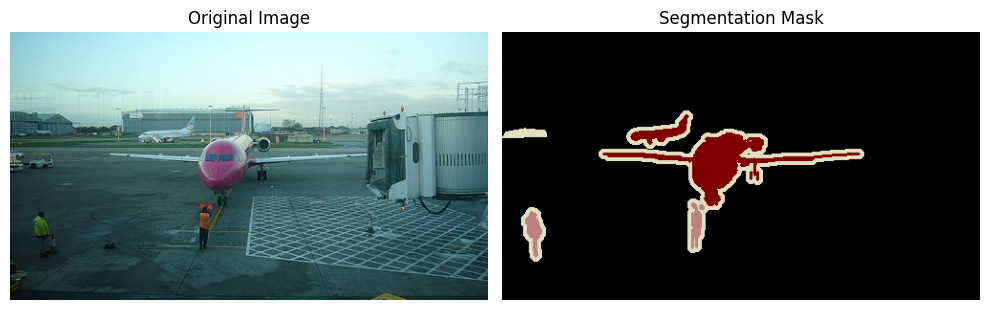

In [8]:
image = Image.open(img_path)
mask = Image.open(mask_path)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title("Segmentation Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

In [10]:
image_set_dir = os.path.join(base_path, "ImageSets/Segmentation")

# 获取训练和验证图像 ID 列表
with open(os.path.join(image_set_dir, "train.txt"), "r") as f:
    train_ids = f.read().splitlines()

with open(os.path.join(image_set_dir, "val.txt"), "r") as f:
    val_ids = f.read().splitlines()

In [11]:
import tensorflow as tf
import numpy as np

IMG_SIZE = 128

def load_image_and_mask(image_id, base_path):
    img_path = os.path.join(base_path, "JPEGImages", image_id + ".jpg")
    mask_path = os.path.join(base_path, "SegmentationClass", image_id + ".png")

    image = Image.open(img_path).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
    mask = Image.open(mask_path).resize((IMG_SIZE, IMG_SIZE), resample=Image.NEAREST)

    # 将 ignore 类转化为 背景类
    mask_array = np.array(mask)
    mask_array[mask_array == 255] = 0

    image = tf.convert_to_tensor(np.array(image), dtype=tf.float32) / 255.0  # 归一化
    mask = tf.convert_to_tensor(mask_array, dtype=tf.int32)

    return image, mask

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(tf.expand_dims(mask, -1))
        mask = tf.squeeze(mask, -1)

    image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
    mask = tf.image.random_crop(mask, size=[IMG_SIZE, IMG_SIZE])

    image = tf.image.random_brightness(image, 0.1)
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, mask

In [13]:
def build_dataset(image_ids, base_dir, training=False):
    def generator():
        for img_id in image_ids:
            yield load_image_and_mask(img_id, base_dir)

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE), dtype=tf.int32)
        )
    )

    if training:
        dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(500).repeat().batch(32).prefetch(tf.data.AUTOTUNE)
    else:
        dataset = dataset.batch(32)

    return dataset

In [14]:
# 构建训练和验证集 Dataset
train_dataset = build_dataset(train_ids, base_path, training=True)
val_dataset = build_dataset(val_ids, base_path, training=False)

In [ ]:
for images, masks in train_dataset.take(1):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(images[0])
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(masks[0])
    plt.title("Segmentation Mask")
    plt.axis("off")
    plt.show()

---

### 构建模型

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
def unet_model(img_size=128, output_channels=21):
    inputs = layers.Input(shape=(img_size, img_size, 3))

    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)

    x = layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')(x)

    outputs = layers.Conv2D(output_channels, 1, activation='softmax')(x)

    return models.Model(inputs, outputs)

In [ ]:
CLASS_WEIGHTS = tf.constant([0.2] + [1.0]*20, dtype=tf.float32)

def weighted_sparse_categorical_crossentropy(y_true, y_pred):
    ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    y_true_int = tf.cast(y_true, tf.int32)
    weights = tf.gather(CLASS_WEIGHTS, y_true_int)
    return ce * tf.cast(weights, tf.float32)

In [ ]:
IMG_SIZE = 128
NUM_CLASSES = 21  # PASCAL VOC 2012 有 20 个类 + 背景

model = unet_model(img_size=IMG_SIZE, output_channels=NUM_CLASSES)

model.compile(optimizer='adam',
              loss=weighted_sparse_categorical_crossentropy,
              metrics=['accuracy'])

model.summary()

In [ ]:
EPOCHS = 2

history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

Epoch 1/2
   1020/Unknown 263s 248ms/step - accuracy: 0.7301 - loss: 0.9599

In [ ]:
def create_mask(pred_mask):
    return tf.argmax(pred_mask, axis=-1)

def display_prediction(image, true_mask, pred_mask):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15, 5))
    titles = ['Image', 'True Mask', 'Predicted Mask']
    display_list = [image, true_mask, pred_mask]
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(titles[i])
        if i == 0:
            plt.imshow(display_list[i])
        else:
            plt.imshow(display_list[i], cmap='jet', vmin=0, vmax=20)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_predictions(model, dataset, num_samples=3):
    for images, masks in dataset.take(1):
        preds = model.predict(images)
        for i in range(num_samples):
            image = images[i].numpy()
            true_mask = masks[i].numpy()
            pred_mask = create_mask(preds[i]).numpy()
            display_prediction(image, true_mask, pred_mask)


In [ ]:
visualize_predictions(model, val_dataset, num_samples=3)